In [262]:
#pip install vaderSentiment

# PROJECT NAME

### PROJECT MEMBERS

In [263]:
#Research Question and Background
#Hypothesis

# Overall question
- Does emotion(postive/negative) influence reaction time
    - fear
- Does isolation affect emotion
- Emotion and memory
    - Happy, sad, fear, sentimental, bored, depression
    - Does music help
    - Does being happy/sad/mad help
    - Enviornment 
        - Loction of learning, learning at school Environment help retain knowledge 
            -Does the emotion in that environment affect it
        - How well can people adapt to forced learning measures
        - 
     - Does body posture affect memory
     - Do drugs imporve memory
         - Does time of consumtion matter
     - 
             
    
- Emotion and music

# Emotions that we want to look at:
- FEAR
- ANGER
- SADNESS
- SENTIMENTAL

# Regions in the brain we want to look at:
- Amygdala
- Temporal lobe
- Prefrontal Cortex
- Hippocampus


# I. Set Up

In [1]:
from lisc import Counts
from lisc.utils.db import SCDB
from lisc.plts.counts import *
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

#Data Import
hippDf = pd.read_csv('hippoCorpusV2.csv')
islandersDf = pd.read_csv('Islander_data.csv')

# II. Data Cleaning


Going to focus on these columns and check for null values:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened

In [2]:
#Check for null values, if null value found returns True
print('AnnotatorAge null values ... ',hippDf['annotatorAge'].isnull().values.any())
print('Story null values ...        ',hippDf['story'].isnull().values.any())
print('Distracted null values ...   ', hippDf['distracted'].isnull().values.any())
print('Draining null values ...     ', hippDf['draining'].isnull().values.any())
print('Frequency null values ...    ', hippDf['frequency'].isnull().values.any())
print('Importance null values ...   ', hippDf['importance'].isnull().values.any())
print('LTSinceEvent null values ... ', hippDf['logTimeSinceEvent'].isnull().values.any())
print('Similarity null values ...   ', hippDf['similarity'].isnull().values.any())
print('Stressful null values ...    ', hippDf['stressful'].isnull().values.any())
print('TimeSinceEvent null values ..', hippDf['timeSinceEvent'].isnull().values.any())


AnnotatorAge null values ...  True
Story null values ...         False
Distracted null values ...    False
Draining null values ...      False
Frequency null values ...     True
Importance null values ...    True
LTSinceEvent null values ...  False
Similarity null values ...    True
Stressful null values ...     False
TimeSinceEvent null values .. False


As we can see there are some null values which is expected based on the dataset the was provided. Since we are interested in the age of the indivduals and their emotion we are going to drop any row with a NaN value in the AnnotatorAge column

In [3]:
noNaNHippDf = hippDf.dropna(subset=['annotatorAge'])


Ensuring that there are no more NaN values

In [4]:
noNaNHippDf['annotatorAge'].unique()

array([25., 35., 30., 18., 50., 40., 45., 55.])


From this, we can see that there are 8 unique age variables. For this project, we will classify the age bucket 18 and 25 as **'Youth'**, 30,35,40 as **'Adults'**, and 45,50,55 as **'Seniors'** into a new column called **"AgeGroup"**

In [35]:
#Categorizes annotatorAge into different age groups
def ageGroup(row):
    if row['annotatorAge'] == 18 or row['annotatorAge'] == 25:
        return 'Youth'
    elif row['annotatorAge'] == 30 or row['annotatorAge'] == 35 or row['annotatorAge'] == 40:
        return 'Adult'
    elif row['annotatorAge'] == 45 or row['annotatorAge'] == 50 or row['annotatorAge'] == 55:
        return 'Senior'
    else:
        return None

In [6]:
ageKey = noNaNHippDf.apply(lambda row: ageGroup(row),axis=1)
ageKey

0        Youth
1        Youth
2        Adult
3        Adult
4        Youth
         ...  
6849     Adult
6850     Youth
6851     Adult
6852     Adult
6853    Senior
Length: 6831, dtype: object

In [7]:
noNaNHippDf['AgeGroup'] = ageKey


/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_66056/2312913534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noNaNHippDf['AgeGroup'] = ageKey


In [8]:
noNaNHippDf['AgeGroup'].unique()

array(['Youth', 'Adult', 'Senior'], dtype=object)

## Splitting data by group
Splitting the data with the memType column with **"recalled"**,**"imagined"**, and **"retold"**

In [9]:
recalled_df = noNaNHippDf[noNaNHippDf['memType']=="recalled"]
imagined_df = noNaNHippDf[noNaNHippDf['memType']=="imagined"]
retold_df = noNaNHippDf[noNaNHippDf['memType']=="retold"]


Going to focus on these columns:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened

- recAgnPairId: ID of the recalled story that corresponds to this retold story (null for imagined stories). Group on   this variable to get the recalled-retold pairs.


In [10]:
newRecalled = recalled_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup','recAgnPairId']]
newImagined = imagined_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup','recAgnPairId']]
newRetold = retold_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup','recAgnPairId']]

# III. Performing text comparison
We are going to look at how similar the stories are between recalled and retold using the spacy package. As a reminder the recalled group is recalling a previous story from their life and the retold group is trying to retell the same story they gave previously based on the summary that they created after they told their start in the recalled group


### We are going to make a new table that combines the recalled story and the retold story so that we can more easily apply the spacy package to it

Need to find the unique id's that link the two data sections together

In [23]:
idTags = hippDf['recAgnPairId'].unique()
#Need to remove the null tag
indexOfNull = 0
newIdTags = np.delete(idTags,indexOfNull)
newIdTags

array(['304SM51WA4QG34IRAVFYVE1S8XNSBV', '304SM51WA4QG34IRAVFYVE1SAOBSB3',
       '308Q0PEVB9Z8LX0Y7Z7O060F6NK9IJ', ...,
       '3ZV9H2YQQET47QVNF7ATAK61QT9W3C', '3ZV9H2YQQET47QVNF7ATAK61TBE3WR',
       '3ZY8KE4ISKPJZ21KN8HT1QGYU5NQVO'], dtype=object)

Now that we have all the unique tags we need to find the recalled data and merge it with the retold data

In [22]:
hippDf.loc[hippDf['recAgnPairId'] == '308XBLVESJQ42PIEV6FT54WWN37BRA']

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent
26,3OJSZ2ATDTISVQHQLIQAX154MTN576,612,3MFQXXSF,30.0,man,white,1.0,1.0,5.0,5.0,...,finding out that the baby is a girl.,1.0,308XBLVESJQ42PIEV6FT54WWN37BRA,NaN,NaN,NaN,About seven and a half months ago I found out ...,1.0,I found out I am going to be a father. My wif...,2.400000e+02
27,308XBLVESJQ42PIEV6FT54WWN37BRA,786,3MFQXXSF,30.0,man,white,1.0,4.0,5.0,5.0,...,Finding out it was a Girl,0.5,308XBLVESJQ42PIEV6FT54WWN37BRA,308XBLVESJQ42PIEV6FT54WWN37BRA,NaN,NaN,The biggest thing to happen to me is finding o...,4.0,I found out I am going to be a father. My wif...,6.666667e+29


In [24]:
listOfLists = []
secondKeyStory = []
deltaOfTime = []
for tagNumber in range(len(newIdTags)):
    #Get df of unique tag
    tagIds = hippDf[hippDf['recAgnPairId'] == newIdTags[tagNumber]]
    #Grab the first one and add it to the list
    mainVal = tagIds.iloc[0]
    #Take the story of the second
    secondStory = tagIds['story'].iloc[1]
    #Check that the data works right
    timeSinceRe = tagIds['timeSinceEvent'].iloc[1]
    
    
    #Add them to a list to make a DF out of
    listOfLists.append(mainVal)
    secondKeyStory.append(secondStory)
    deltaOfTime.append(timeSinceRe)
    
    
    

In [15]:
recalledAndRetold = pd.DataFrame(listOfLists)
recalledAndRetold['retold stories'] = secondKeyStory
recalledAndRetold['time since recalled'] = deltaOfTime
recalledAndRetold.head()

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent,AgeGroup,retold stories,time since recalled
9,3YGXWBAF713GBO8MYUFB8VR53RKC4M,7228,4MFUAYFX,25.0,man,hisp,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,Me and my girlfriend had gone to the Los Angel...,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth,About a month ago me and my girlfriend went to...,30
12,35LDD5557BQEYC9GWBW5I8LCG5AKMA,4925,HE3SATVD,30.0,man,black,3.0,4.0,3.0,3.0,...,NaN,NaN,NaN,My Cousin's WeddingWe went to my cousin’s wedd...,4.0,My life was endangered for doing research on p...,180.0,Adult,It happen 2 weeks ago at the library. Stared o...,14
18,3NAPMVF0ZX10WTY33ZOCZU2SUYL72I,6488,AXJ0SHSA,30.0,man,white,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,I remember the event like it was just yesterda...,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult,About a week ago a received a phone call from ...,7
21,3C8HJ7UOP8G9N782WCZF5N9PKNHZMN,1405,2WT572QN,30.0,woman,hisp,1.0,1.0,4.0,4.0,...,NaN,NaN,NaN,"When my now four year old son was born, we wer...",1.0,My four year old son needed foot surgery. My h...,60.0,Adult,A memorable event that I have recently had hap...,7
26,3OJSZ2ATDTISVQHQLIQAX154MTN576,612,3MFQXXSF,30.0,man,white,1.0,1.0,5.0,5.0,...,NaN,NaN,NaN,About seven and a half months ago I found out ...,1.0,I found out I am going to be a father. My wif...,240.0,Adult,The biggest thing to happen to me is finding o...,666666666666666633010587107328


As we can see in row 26 the data in the time since recalled column makes no sense. After doing further investigation this error orginates from how the data was recorded. So to avoid skewed results we are going to remove any result that is above 1111111 days. We chose this point from looking at the data and seeing that it jumps from 780 days to 
1111111 which is a jump from 2.14 years to 3,044 years.

In [25]:
cleanedRecalledAndRetold = recalledAndRetold[recalledAndRetold['time since recalled'] < 1111111]
cleanedRecalledAndRetold.head()

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent,AgeGroup,retold stories,time since recalled
9,3YGXWBAF713GBO8MYUFB8VR53RKC4M,7228,4MFUAYFX,25.0,man,hisp,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,Me and my girlfriend had gone to the Los Angel...,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth,About a month ago me and my girlfriend went to...,30
12,35LDD5557BQEYC9GWBW5I8LCG5AKMA,4925,HE3SATVD,30.0,man,black,3.0,4.0,3.0,3.0,...,NaN,NaN,NaN,My Cousin's WeddingWe went to my cousin’s wedd...,4.0,My life was endangered for doing research on p...,180.0,Adult,It happen 2 weeks ago at the library. Stared o...,14
18,3NAPMVF0ZX10WTY33ZOCZU2SUYL72I,6488,AXJ0SHSA,30.0,man,white,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,I remember the event like it was just yesterda...,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult,About a week ago a received a phone call from ...,7
21,3C8HJ7UOP8G9N782WCZF5N9PKNHZMN,1405,2WT572QN,30.0,woman,hisp,1.0,1.0,4.0,4.0,...,NaN,NaN,NaN,"When my now four year old son was born, we wer...",1.0,My four year old son needed foot surgery. My h...,60.0,Adult,A memorable event that I have recently had hap...,7
31,324G5B4FB4UT0JVPOCKYG69D7A807S,1834,AKT7XTAI,45.0,man,black,2.0,2.0,5.0,5.0,...,NaN,NaN,NaN,"I fell down a flight of stairs in my home, in ...",2.0,I fell down the stairs in my home and suffered...,240.0,Senior,"Last May, I had just come upstairs to get rea...",120


Lets check and make sure that there are no more extraneous data points

In [26]:
cleanedRecalledAndRetold['time since recalled'].unique()

array([30, 14, 7, 120, 60, 90, 150, 42, 56, 35, 21, 360, 28, 49, 510, 180,
       720], dtype=object)

Now lets run the spacy package

In [27]:
import spacy
nlp = spacy.load('en_core_web_lg')


In [28]:
test1 = cleanedRecalledAndRetold['story'].iloc[0]
test2 = cleanedRecalledAndRetold['retold stories'].iloc[0]
doc1 = nlp(test1)
doc2 = nlp(test2)


In [29]:
print(doc1.similarity(doc2))

0.9935622763567541


In [30]:
def applyingSpacy(df):
    sim_score = []
    
    for i in range(len(df)):
        ogStory = df['story'].iloc[i]
        newStory = df['retold stories'].iloc[i]
        nlpComp1 = nlp(ogStory)
        nlpComp2 = nlp(newStory)
        sim_score.append(nlpComp1.similarity(nlpComp2))
        
    return sim_score

In [31]:
sim_scores = applyingSpacy(cleanedRecalledAndRetold)

In [32]:
print(cleanedRecalledAndRetold.shape)
print(len(sim_scores))

(95, 26)
95


In [33]:
cleanedRecalledAndRetold['spacy_sim'] = sim_scores
cleanedRecalledAndRetold.head()

/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_66056/1405917381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedRecalledAndRetold['spacy_sim'] = sim_scores


,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,similarity,similarityReason,story,stressful,summary,timeSinceEvent,AgeGroup,retold stories,time since recalled,spacy_sim
9,3YGXWBAF713GBO8MYUFB8VR53RKC4M,7228,4MFUAYFX,25.0,man,hisp,1.0,1.0,2.0,2.0,...,NaN,NaN,Me and my girlfriend had gone to the Los Angel...,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth,About a month ago me and my girlfriend went to...,30,0.993562
12,35LDD5557BQEYC9GWBW5I8LCG5AKMA,4925,HE3SATVD,30.0,man,black,3.0,4.0,3.0,3.0,...,NaN,NaN,My Cousin's WeddingWe went to my cousin’s wedd...,4.0,My life was endangered for doing research on p...,180.0,Adult,It happen 2 weeks ago at the library. Stared o...,14,0.971579
18,3NAPMVF0ZX10WTY33ZOCZU2SUYL72I,6488,AXJ0SHSA,30.0,man,white,4.0,4.0,4.0,4.0,...,NaN,NaN,I remember the event like it was just yesterda...,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult,About a week ago a received a phone call from ...,7,0.983846
21,3C8HJ7UOP8G9N782WCZF5N9PKNHZMN,1405,2WT572QN,30.0,woman,hisp,1.0,1.0,4.0,4.0,...,NaN,NaN,"When my now four year old son was born, we wer...",1.0,My four year old son needed foot surgery. My h...,60.0,Adult,A memorable event that I have recently had hap...,7,0.994450
31,324G5B4FB4UT0JVPOCKYG69D7A807S,1834,AKT7XTAI,45.0,man,black,2.0,2.0,5.0,5.0,...,NaN,NaN,"I fell down a flight of stairs in my home, in ...",2.0,I fell down the stairs in my home and suffered...,240.0,Senior,"Last May, I had just come upstairs to get rea...",120,0.993332


In [34]:
print(cleanedRecalledAndRetold.columns)

Index(['AssignmentId', 'WorkTimeInSeconds', 'WorkerId', 'annotatorAge',
       'annotatorGender', 'annotatorRace', 'distracted', 'draining',
       'frequency', 'importance', 'logTimeSinceEvent', 'mainEvent', 'memType',
       'mostSurprising', 'openness', 'recAgnPairId', 'recImgPairId',
       'similarity', 'similarityReason', 'story', 'stressful', 'summary',
       'timeSinceEvent', 'AgeGroup', 'retold stories', 'time since recalled',
       'spacy_sim'],
      dtype='object')


Need to regroup ages using the age function

In [36]:
ageKey = cleanedRecalledAndRetold.apply(lambda row: ageGroup(row),axis=1)


9       Youth
12      Adult
18      Adult
21      Adult
31     Senior
        ...  
513    Senior
516     Adult
519    Senior
522    Senior
525     Adult
Length: 95, dtype: object

In [37]:
cleanedRecalledAndRetold['AgeGroup'] = ageKey

/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_66056/3990097904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedRecalledAndRetold['AgeGroup'] = ageKey


<AxesSubplot:xlabel='time since recalled', ylabel='spacy_sim'>

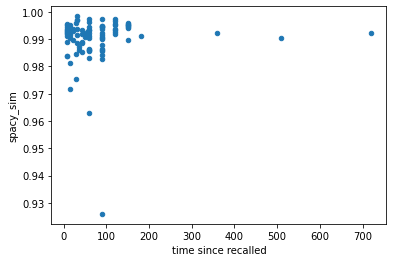

In [40]:
cleanedRecalledAndRetold.plot.scatter(x='time since recalled', y = 'spacy_sim')

<AxesSubplot:xlabel='time since recalled', ylabel='spacy_sim'>

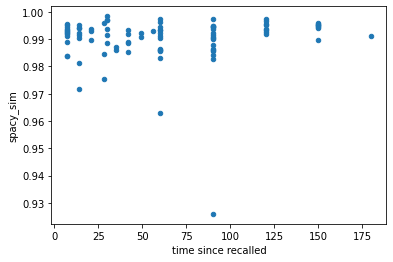

In [41]:
test = cleanedRecalledAndRetold[cleanedRecalledAndRetold['time since recalled'] < 250]
test.plot.scatter(x='time since recalled', y = 'spacy_sim')

In [42]:
import numpy 
import pandas
import matplotlib.pyplot as plt
import seaborn

In [43]:
_ages = ['Youth', 'Adult', 'Senior']

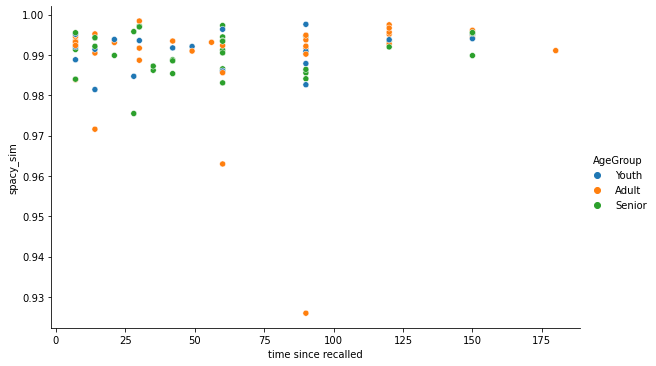

In [45]:
seaborn.relplot(data=test, x='time since recalled', y='spacy_sim', hue='AgeGroup', hue_order=_ages, aspect=1.61)
plt.show()

# III. Exploratory Data Analysis

### This is the method that will be used to calculate the sentiment score

In [288]:
def sentScore(dataFrame):
    s_score = []
    s_rating = []
    sentiment_obj = SentimentIntensityAnalyzer()
    for i in range(len(dataFrame)):
        s_score.append(sentiment_obj.polarity_scores(dataFrame.iloc[i,1]))
        comp_score = s_score[i]['compound']
        if comp_score > 0.05:
            s_rating.append("Positive")
        elif comp_score <= -0.05:
            s_rating.append("Negative")
        else:
            s_rating.append("Neutral")
    return [s_score, s_rating]

### IIIa. Sentiment Analysis For Recalled

In [289]:
newRecalled.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,recAgnPairId
1,25.0,"The day started perfectly, with a great drive ...",1.0,1.0,3.0,4.0,4.499810,a concert.,NaN,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,NaN
3,30.0,"Five months ago, my niece and nephew were born...",1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,NaN,2.0,My sister gave birth to my twin niece and neph...,150.0,Adult,NaN
5,35.0,Burning Man metamorphoses was perfect. I am de...,1.0,1.0,5.0,5.0,3.401197,about my journey this year to Burning Man meta...,NaN,1.0,It is always a journey for me to go to burning...,30.0,Adult,NaN
7,18.0,"Dear Diary,I would say this happened about 3 m...",1.0,4.0,5.0,5.0,4.499810,a bad driving experience on the way to Acadia ...,NaN,1.0,What happened is that I was on a trip with my ...,90.0,Youth,NaN
10,25.0,About a month ago me and my girlfriend went to...,1.0,1.0,2.0,3.0,3.401197,a trip to the zoo.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,304SM51WA4QG34IRAVFYVE1S8XNSBV


In [290]:
recalledSentValues = sentScore(newRecalled)

In [291]:
newRecalled['sentiment_score'] = recalledSentValues[0]
newRecalled['sentiment'] = recalledSentValues[1]


C:\Users\kstev\AppData\Local\Temp\ipykernel_15732\1647381943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRecalled['sentiment_score'] = recalledSentValues[0]
C:\Users\kstev\AppData\Local\Temp\ipykernel_15732\1647381943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRecalled['sentiment'] = recalledSentValues[1]


In [292]:
newRecalled.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,recAgnPairId,sentiment_score,sentiment
1,25.0,"The day started perfectly, with a great drive ...",1.0,1.0,3.0,4.0,4.499810,a concert.,NaN,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,NaN,"{'neg': 0.03, 'neu': 0.704, 'pos': 0.266, 'com...",Positive
3,30.0,"Five months ago, my niece and nephew were born...",1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,NaN,2.0,My sister gave birth to my twin niece and neph...,150.0,Adult,NaN,"{'neg': 0.041, 'neu': 0.794, 'pos': 0.165, 'co...",Positive
5,35.0,Burning Man metamorphoses was perfect. I am de...,1.0,1.0,5.0,5.0,3.401197,about my journey this year to Burning Man meta...,NaN,1.0,It is always a journey for me to go to burning...,30.0,Adult,NaN,"{'neg': 0.053, 'neu': 0.825, 'pos': 0.122, 'co...",Positive
7,18.0,"Dear Diary,I would say this happened about 3 m...",1.0,4.0,5.0,5.0,4.499810,a bad driving experience on the way to Acadia ...,NaN,1.0,What happened is that I was on a trip with my ...,90.0,Youth,NaN,"{'neg': 0.065, 'neu': 0.856, 'pos': 0.079, 'co...",Positive
10,25.0,About a month ago me and my girlfriend went to...,1.0,1.0,2.0,3.0,3.401197,a trip to the zoo.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,304SM51WA4QG34IRAVFYVE1S8XNSBV,"{'neg': 0.009, 'neu': 0.883, 'pos': 0.108, 'co...",Positive


### IIIb. Sentiment Analysis For Imagined

In [293]:
newImagined.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,recAgnPairId
0,25.0,"Concerts are my most favorite thing, and my bo...",1.0,1.0,NaN,3.0,4.499810,attending a show,3.0,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,NaN
2,35.0,It seems just like yesterday but today makes f...,1.0,1.0,NaN,4.0,5.010635,my sister having her twins a little early,3.0,1.0,My sister gave birth to my twin niece and neph...,150.0,Adult,NaN
4,25.0,About a month ago I went to burning man. I was...,2.0,2.0,NaN,3.0,3.401197,the consequences of going to burning man,4.0,4.0,It is always a journey for me to go to burning...,30.0,Youth,NaN
6,35.0,"Play stupid games, win stupid prizes road trip...",3.0,1.0,NaN,4.0,4.499810,a scary car ride where we swerved on our way t...,1.0,2.0,What happened is that I was on a trip with my ...,90.0,Adult,NaN
8,25.0,I wanted to write about one of the best days i...,1.0,1.0,NaN,4.0,3.401197,my girlfriend and I going to the zoo.,4.0,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,NaN


In [294]:
imaginedSentValues = sentScore(newImagined)
newImagined['sentiment_score'] = imaginedSentValues[0]
newImagined['sentiment'] = imaginedSentValues[1]
newImagined.head()

C:\Users\kstev\AppData\Local\Temp\ipykernel_15732\228504564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newImagined['sentiment_score'] = imaginedSentValues[0]
C:\Users\kstev\AppData\Local\Temp\ipykernel_15732\228504564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newImagined['sentiment'] = imaginedSentValues[1]


,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,recAgnPairId,sentiment_score,sentiment
0,25.0,"Concerts are my most favorite thing, and my bo...",1.0,1.0,NaN,3.0,4.499810,attending a show,3.0,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,NaN,"{'neg': 0.011, 'neu': 0.714, 'pos': 0.274, 'co...",Positive
2,35.0,It seems just like yesterday but today makes f...,1.0,1.0,NaN,4.0,5.010635,my sister having her twins a little early,3.0,1.0,My sister gave birth to my twin niece and neph...,150.0,Adult,NaN,"{'neg': 0.023, 'neu': 0.826, 'pos': 0.151, 'co...",Positive
4,25.0,About a month ago I went to burning man. I was...,2.0,2.0,NaN,3.0,3.401197,the consequences of going to burning man,4.0,4.0,It is always a journey for me to go to burning...,30.0,Youth,NaN,"{'neg': 0.052, 'neu': 0.872, 'pos': 0.076, 'co...",Positive
6,35.0,"Play stupid games, win stupid prizes road trip...",3.0,1.0,NaN,4.0,4.499810,a scary car ride where we swerved on our way t...,1.0,2.0,What happened is that I was on a trip with my ...,90.0,Adult,NaN,"{'neg': 0.099, 'neu': 0.828, 'pos': 0.073, 'co...",Negative
8,25.0,I wanted to write about one of the best days i...,1.0,1.0,NaN,4.0,3.401197,my girlfriend and I going to the zoo.,4.0,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,NaN,"{'neg': 0.008, 'neu': 0.841, 'pos': 0.151, 'co...",Positive


### IIIc. Sentiment Analysis For Retold

In [295]:
newRetold

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,recAgnPairId
9,25.0,Me and my girlfriend had gone to the Los Angel...,1.0,1.0,2.0,2.0,5.347108,a trip to the Los Angeles zoo with my girlfriend.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth,304SM51WA4QG34IRAVFYVE1S8XNSBV
12,30.0,My Cousin's WeddingWe went to my cousin’s wedd...,3.0,4.0,3.0,3.0,5.192957,my cousin's wedding,NaN,4.0,My life was endangered for doing research on p...,180.0,Adult,304SM51WA4QG34IRAVFYVE1SAOBSB3
18,30.0,I remember the event like it was just yesterda...,4.0,4.0,4.0,4.0,4.094345,my friend's arrest,NaN,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult,308Q0PEVB9Z8LX0Y7Z7O060F6NK9IJ
21,30.0,"When my now four year old son was born, we wer...",1.0,1.0,4.0,4.0,4.094345,my son's foot surgery,NaN,1.0,My four year old son needed foot surgery. My h...,60.0,Adult,308Q0PEVB9Z8LX0Y7Z7O060FETEI96
26,30.0,About seven and a half months ago I found out ...,1.0,1.0,5.0,5.0,5.480639,Finding out I am going to be a father.,NaN,1.0,I found out I am going to be a father. My wif...,240.0,Adult,308XBLVESJQ42PIEV6FT54WWN37BRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,55.0,Another of my little birds have left the nest....,1.0,2.0,4.0,4.0,4.094345,training my coworker to her new store manager ...,NaN,1.0,My trainee was finally promoted to manager aft...,60.0,Senior,NaN
6726,25.0,Earlier this year there was a domestic violenc...,1.0,5.0,5.0,5.0,5.598422,me being involved in a domestic violence incident,NaN,4.0,"Got in a verbal argument with wife, which led ...",270.0,Youth,NaN
6727,25.0,I remember a time when i was going to my mothe...,3.0,4.0,4.0,3.0,2.639057,brother getting engaged,NaN,4.0,{},14.0,Youth,NaN
6728,18.0,When I graduated high I was initially very hap...,4.0,3.0,4.0,4.0,5.010635,about graduating high shcool,NaN,2.0,I graduated high school. After that I realized...,150.0,Youth,NaN


In [296]:
retoldSentValues = sentScore(newRetold)
newRetold['sentiment_score'] = retoldSentValues[0]
newRetold['sentiment'] = retoldSentValues[1]
newRetold.head()

C:\Users\kstev\AppData\Local\Temp\ipykernel_15732\4011508452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRetold['sentiment_score'] = retoldSentValues[0]
C:\Users\kstev\AppData\Local\Temp\ipykernel_15732\4011508452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRetold['sentiment'] = retoldSentValues[1]


,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,recAgnPairId,sentiment_score,sentiment
9,25.0,Me and my girlfriend had gone to the Los Angel...,1.0,1.0,2.0,2.0,5.347108,a trip to the Los Angeles zoo with my girlfriend.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth,304SM51WA4QG34IRAVFYVE1S8XNSBV,"{'neg': 0.033, 'neu': 0.923, 'pos': 0.044, 'co...",Positive
12,30.0,My Cousin's WeddingWe went to my cousin’s wedd...,3.0,4.0,3.0,3.0,5.192957,my cousin's wedding,NaN,4.0,My life was endangered for doing research on p...,180.0,Adult,304SM51WA4QG34IRAVFYVE1SAOBSB3,"{'neg': 0.062, 'neu': 0.853, 'pos': 0.085, 'co...",Positive
18,30.0,I remember the event like it was just yesterda...,4.0,4.0,4.0,4.0,4.094345,my friend's arrest,NaN,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult,308Q0PEVB9Z8LX0Y7Z7O060F6NK9IJ,"{'neg': 0.063, 'neu': 0.702, 'pos': 0.234, 'co...",Positive
21,30.0,"When my now four year old son was born, we wer...",1.0,1.0,4.0,4.0,4.094345,my son's foot surgery,NaN,1.0,My four year old son needed foot surgery. My h...,60.0,Adult,308Q0PEVB9Z8LX0Y7Z7O060FETEI96,"{'neg': 0.05, 'neu': 0.873, 'pos': 0.077, 'com...",Positive
26,30.0,About seven and a half months ago I found out ...,1.0,1.0,5.0,5.0,5.480639,Finding out I am going to be a father.,NaN,1.0,I found out I am going to be a father. My wif...,240.0,Adult,308XBLVESJQ42PIEV6FT54WWN37BRA,"{'neg': 0.009, 'neu': 0.88, 'pos': 0.112, 'com...",Positive


### IV. Visualizations

##### IVa. Visualization for Recalled, Imagined and Retold by Sentiment and Age

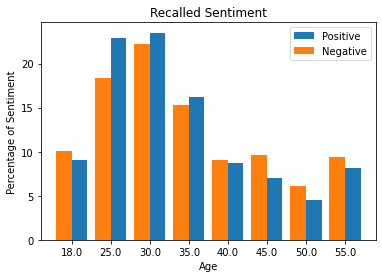

---------- Positive Stats ----------
Age: 18.0 Percentage: 9.019426456984274
Age: 25.0 Percentage: 22.849213691026826
Age: 30.0 Percentage: 23.496762257169287
Age: 35.0 Percentage: 16.23496762257169
Age: 40.0 Percentage: 8.741905642923218
Age: 45.0 Percentage: 7.030527289546716
Age: 50.0 Percentage: 4.4865864939870495
Age: 55.0 Percentage: 8.140610545790935
---------- Negative Stats ----------
Age: 18.0 Percentage: 10.084033613445378
Age: 25.0 Percentage: 18.319327731092436
Age: 30.0 Percentage: 22.18487394957983
Age: 35.0 Percentage: 15.294117647058824
Age: 40.0 Percentage: 9.07563025210084
Age: 45.0 Percentage: 9.57983193277311
Age: 50.0 Percentage: 6.050420168067227
Age: 55.0 Percentage: 9.411764705882353


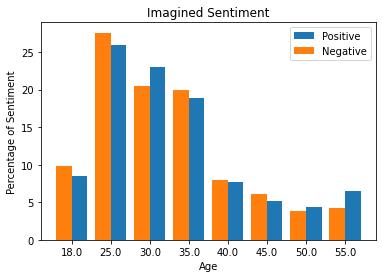

---------- Positive Stats ----------
Age: 18.0 Percentage: 8.540442837776773
Age: 25.0 Percentage: 25.89245368278355
Age: 30.0 Percentage: 23.000451875282423
Age: 35.0 Percentage: 18.84319927699955
Age: 40.0 Percentage: 7.681879801174876
Age: 45.0 Percentage: 5.106190691369182
Age: 50.0 Percentage: 4.428377767736104
Age: 55.0 Percentage: 6.507004066877542
---------- Negative Stats ----------
Age: 18.0 Percentage: 9.885931558935361
Age: 25.0 Percentage: 27.566539923954377
Age: 30.0 Percentage: 20.53231939163498
Age: 35.0 Percentage: 19.96197718631179
Age: 40.0 Percentage: 7.984790874524715
Age: 45.0 Percentage: 6.083650190114068
Age: 50.0 Percentage: 3.802281368821293
Age: 55.0 Percentage: 4.182509505703422


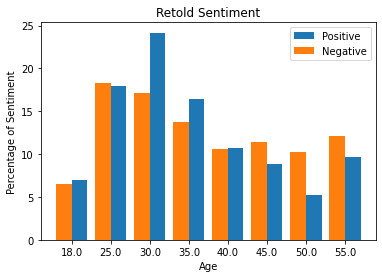

---------- Positive Stats ----------
Age: 18.0 Percentage: 6.999041227229147
Age: 25.0 Percentage: 17.929050814956852
Age: 30.0 Percentage: 24.161073825503358
Age: 35.0 Percentage: 16.39501438159156
Age: 40.0 Percentage: 10.738255033557047
Age: 45.0 Percentage: 8.820709491850431
Age: 50.0 Percentage: 5.273250239693192
Age: 55.0 Percentage: 9.683604985618409
---------- Negative Stats ----------
Age: 18.0 Percentage: 6.4638783269961975
Age: 25.0 Percentage: 18.250950570342205
Age: 30.0 Percentage: 17.110266159695815
Age: 35.0 Percentage: 13.688212927756654
Age: 40.0 Percentage: 10.646387832699618
Age: 45.0 Percentage: 11.406844106463879
Age: 50.0 Percentage: 10.26615969581749
Age: 55.0 Percentage: 12.167300380228136


In [297]:
#Recalled Visualization
X = newRecalled['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newRecalled['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newRecalled[(newRecalled['annotatorAge'] == x) & (newRecalled['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newRecalled[(newRecalled['annotatorAge'] == x) & (newRecalled['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Recalled Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

#Imagined Visualization
X = newImagined['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newImagined['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newImagined[(newImagined['annotatorAge'] == x) & (newImagined['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newImagined[(newImagined['annotatorAge'] == x) & (newImagined['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Imagined Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

#Retold Visualization   
X = newRetold['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newRetold['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newRetold[(newRetold['annotatorAge'] == x) & (newRetold['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newRetold[(newRetold['annotatorAge'] == x) & (newRetold['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Retold Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

##### IVb. Visualization for Recalled, Imagined and Retold by Sentiment and AgeGroup

Text(0.5, 1.0, 'Retold Sentiment')

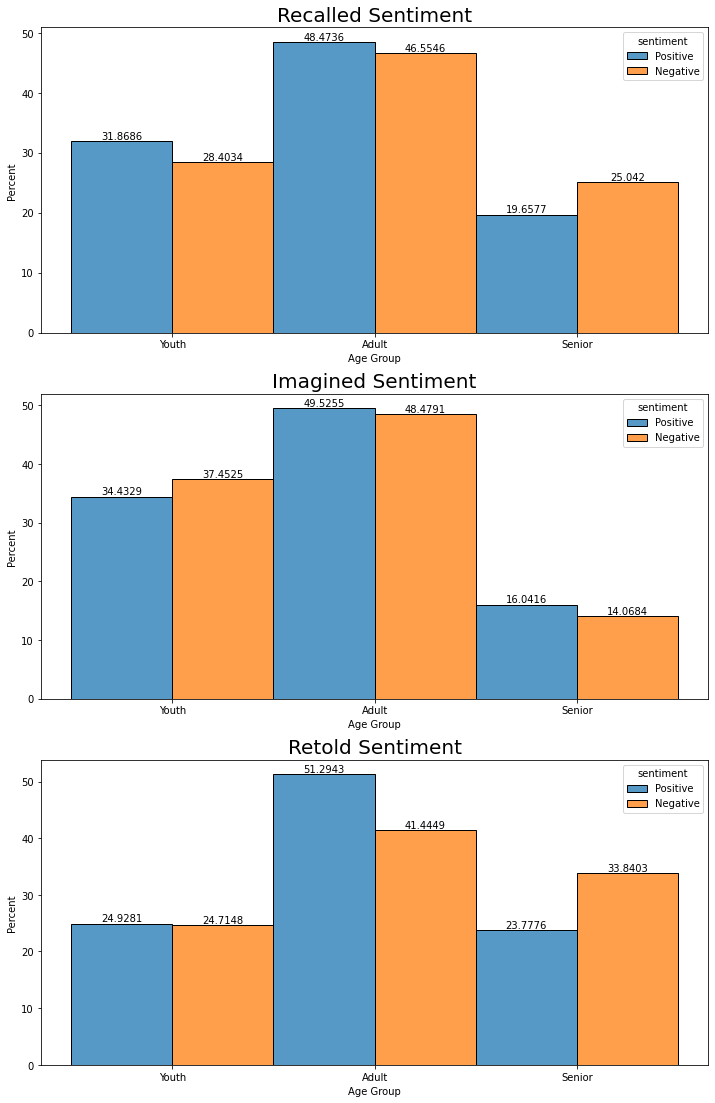

In [298]:
#Plot settings
fig, axes = plt.subplots(3, 1,figsize=(10,15))
fig.tight_layout(h_pad = 4.0)

#Recalled Visualization
graph_2 = sns.histplot(data = newRecalled, x="AgeGroup", hue = 'sentiment', hue_order = ['Positive','Negative'],multiple='dodge', stat = 'percent',common_norm=False,ax=axes[0])
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Age Group')
axes[0].set_title('Recalled Sentiment', fontsize=20)

#Imagined Visualization
graph_2 = sns.histplot(data = newImagined, x="AgeGroup", hue = 'sentiment', hue_order = ['Positive','Negative'],multiple='dodge', stat = 'percent',common_norm=False,ax=axes[1])
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Age Group')
axes[1].set_title('Imagined Sentiment', fontsize=20)

#Retold Visualization
graph_2 = sns.histplot(data = newRetold, x="AgeGroup", hue = 'sentiment', hue_order = ['Positive','Negative'],multiple='dodge', stat = 'percent',common_norm=False,ax=axes[2])
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Age Group')
axes[2].set_title('Retold Sentiment', fontsize=20)

#### IVc. Sentimental Analysis between Retold vs. Recalled Stories

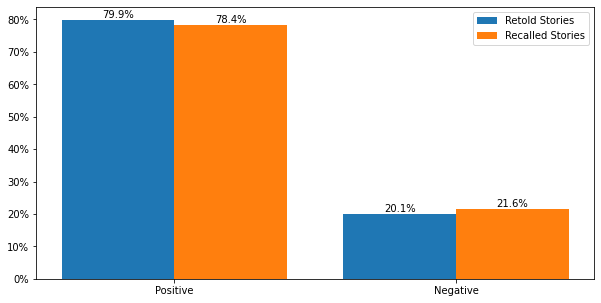

In [299]:
#select positive and negative sentiments (remove neutral sentiment)
posnegRetold = newRetold[(newRetold['sentiment'] == 'Positive') | (newRetold['sentiment'] == 'Negative')]
posnegRecalled = newRecalled[(newRecalled['sentiment'] == 'Positive') | (newRecalled['sentiment'] == 'Negative')]

#plot parameters
x = posnegRetold['sentiment']
y = posnegRecalled['sentiment']
fig, ax = plt.subplots(figsize=(10,5))
values, bins, patches = plt.hist([x, y], bins=np.arange(3)-0.5, label=['Retold Stories', 'Recalled Stories'],density=True)
 
plt.legend(loc='upper right')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
for container in ax.containers:
    labels = [f'{x:.1%}' for x in container.datavalues]
    ax.bar_label(container, labels=labels)
plt.show()

# V. Conclusion and Discussion

In [300]:
#Conclusion